###  Install Required Libraries



In [1]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install requests
%pip install tabulate
%pip install scikit-learn
%pip install nltk
"""

'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install requests\n%pip install tabulate\n%pip install scikit-learn\n%pip install nltk\n'

In [2]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.tools import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiments

In [3]:
SHOTS_NUMBER = ShotPromptingMode.ONE_SHOT

### Description Generation

In [4]:
print("Description STARTING...")
description = generate_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is a comprehensive tool designed for the automated annotation and interpretation of genetic variants specifically in cancer. It aggregates data from various sources to convert DNA modifications to protein changes, predict the functional consequences of mutations, and provide insights into mutation frequencies, gene functions, effects of variants, and their clinical actionability. The project includes functionalities for running local instances, utilizing Docker containers, and integrating with other genomic resources, thereby facilitating high-throughput analyses of genetic data.'


### Actors Extraction

In [5]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='User Researcher', description='Individuals who analyze genetic variants for research purposes.'), Actor(name='Clinician', description='Medical professionals who interpret genetic data for patient care.'), Actor(name='Bioinformatician', description='Specialists who manage and analyze biological data.'), Actor(name='Software Developer', description='Engineers who maintain and develop the Genome Nexus tool.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The defined actors cover the primary roles involved in using the Genome Nexus tool, focusing on research, clinical interpretation, data management, and software development. However, it would be beneficial to include additional roles such as patients or laboratory technicians, who might also interact with the software, either directly or indirectly. This omission limits the comprehensiveness of the user roles defin

### High Level Goals Extraction

In [6]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract high-level goals from software descriptions. Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software. Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions). MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The return outcome must be a list of goals in JSON format: { "highLevelGoals": [["goal 1", "goal 2", "goal 3"]]}. Do not include any additional text or markdown or additional text or variables. The returned high-level goals should be specific and focused on functional user needs.

High Level Goals DONE...
goals=[HighLevelGoal

### Low Level Goals Extraction

In [7]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract low-level goals from high-level goals. The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The returned low-level goals should be specific and focused on the user's needs.

Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Access the genetic variant database in Genome Nexus to analyze cancer-related mutations.', description='Allows the user researcher to find specific genetic variants associated with cancer.', high_level_associated=HighLevelGoal(name='User Researcher', description='The user researcher aims to efficiently anal

### APIs Extraction from Swagger

In [8]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

### APIs Mapping to Low Level Goals

In [9]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
Goal:  Enables user researchers to perform detailed analyses of genetic variants linked to cancer, facilitating research insights.
APIs:  fetchVariantAnnotationPOST

Goal:  Allows user researchers to compile and share insights regarding the clinical significance of mutations in cancer research.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchVariantAnnotationGET

Goal:  Enables clinicians to access and utilize relevant genetic information for their patients' cancer treatment decisions.
APIs:  fetchVariantAnnotationGET},{

Goal:  Assists clinicians in interpreting genetic findings to make informed decisions regarding patient treatment strategies.
APIs:  fetchVariantAnnotationGET

Goal:  Allows bioinformaticians to enhance their analysis processes by combining multiple sources of genomic data within Genome Nexus.
APIs:  fetchVariantAnnotationPOST},{, fetchVariantAnnotationByGenomicLocationPOST, fetchEnsemblTranscriptsByEnsemblFilte

### Mapping Table

In [10]:
print_api_goal_mapping(mappings)

╒═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Low-Level Goal                                                                                                                              │ Mapped APIs                                                                                                             │
╞═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Enables user researchers to perform detailed analyses of genetic variants linked to cancer, facilitating research insights.                 │ fetchVariantAnnotationPOST                                

# Evaluation

### Evaluation: Extracted High Level Goals 

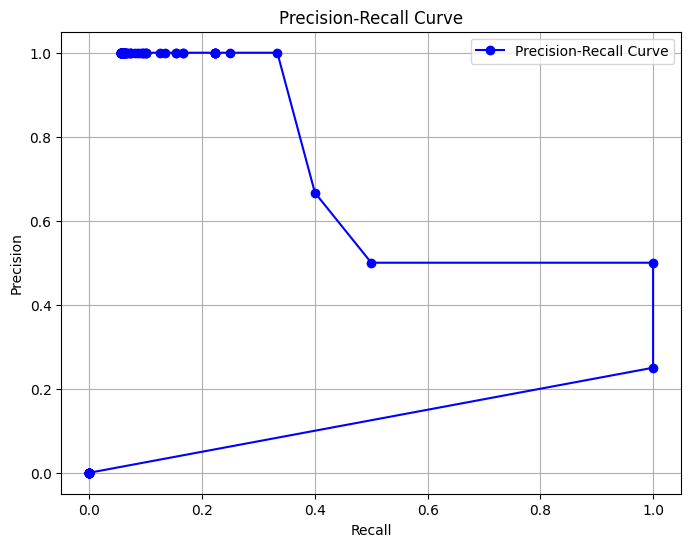

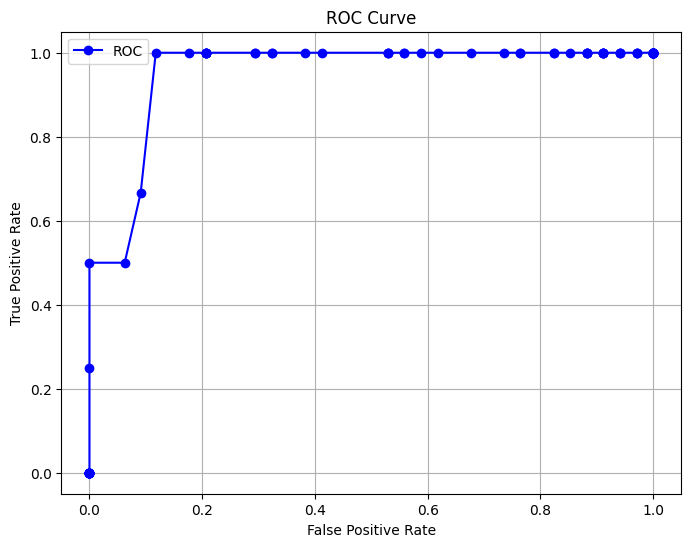

High Level ROC AUC: 0.952456550310579
High Level Precision Recall Curve AUC: 0.5722222216306945


In [11]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


### Evaluation: Extracted Low Level Goals 

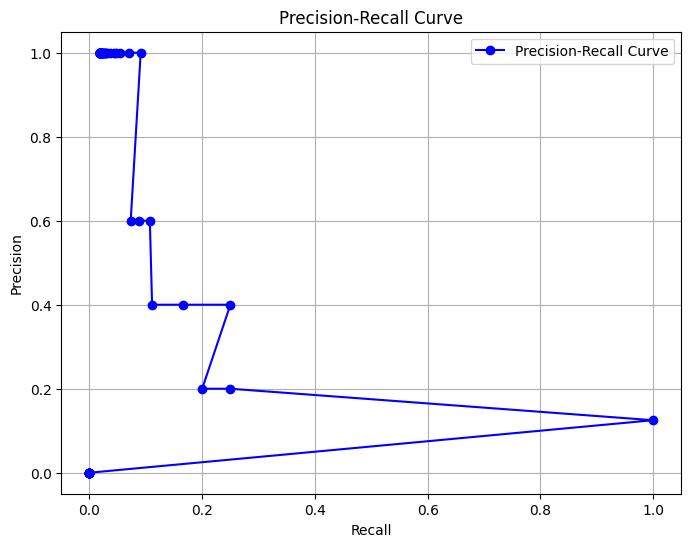

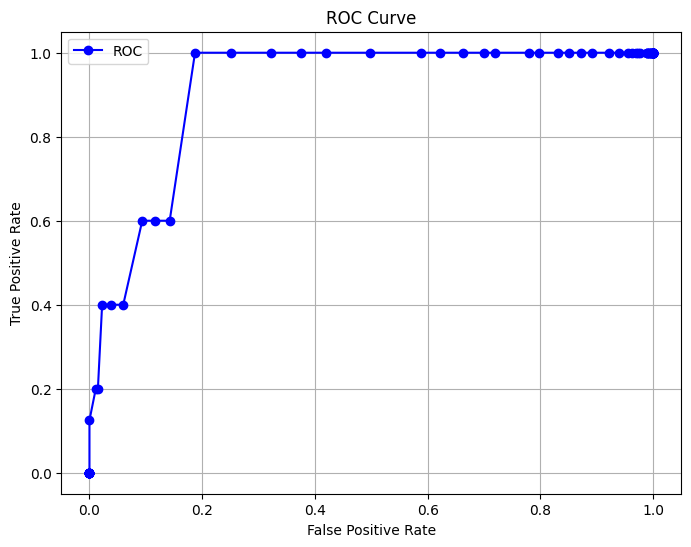

Low Level Goals ROC AUC: 0.9145599249073484
Low Level Goals Precision Recall Curve AUC: 0.20901636119454708


In [12]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

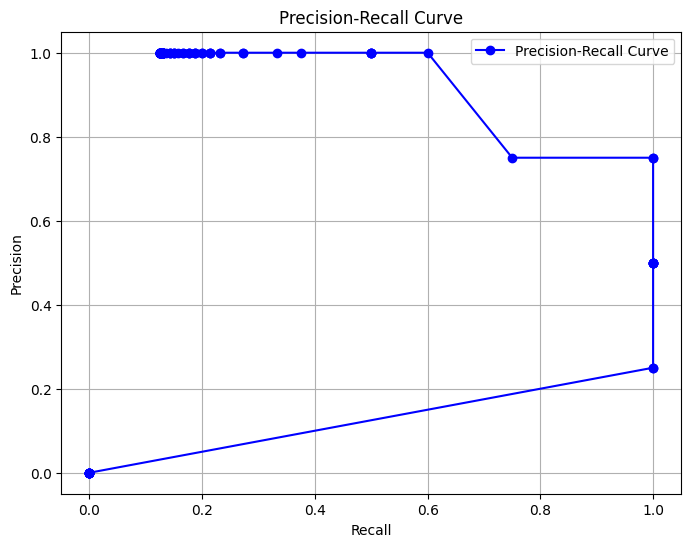

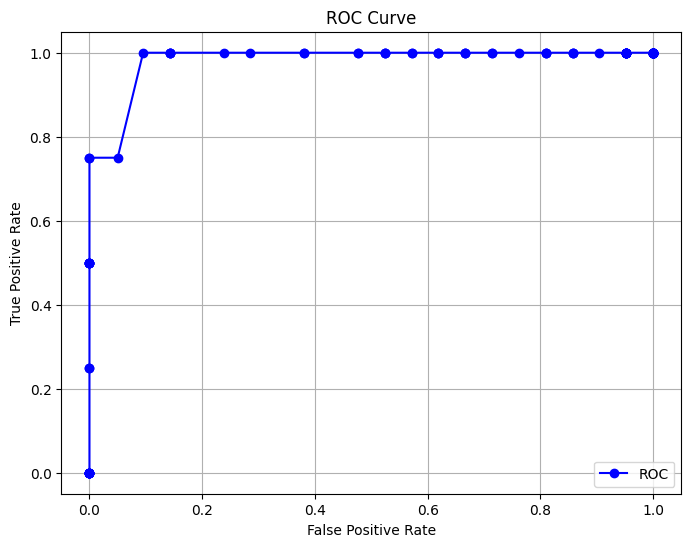

Actors ROC AUC: 0.9818452377257554
Actors Precision Recall Curve AUC: 0.7937499992902083


In [13]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)